In [1]:
import l0module as l0
import torch.nn as nn                                                                                              
import torch

In [2]:
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F

from teacher import Teacher
from plot_history import plot_history, plot_gate_values

from tqdm.notebook import tqdm
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import sys
    
device = torch.device('cuda:0')
normalize = transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
        std = (0.2023, 0.1994, 0.2010))
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=128, shuffle=True,
    num_workers=4, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False,
    num_workers=4, pin_memory=True)


Files already downloaded and verified


In [3]:
from teacher import Teacher

In [4]:
# Load baseline teachers

teacher1 = Teacher()
teacher1.load_state_dict(torch.load("teachers/model_0/best.checkpoint", map_location="cpu")["model_state_dict"])
teacher2 = Teacher()
teacher2.load_state_dict(torch.load("teachers/model_1/best.checkpoint", map_location="cpu")["model_state_dict"])

teacher1

in _make_layers [Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

Teacher(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (14): ReLU(inplace=True)
    (15): 

In [5]:
# Make big student from two teachers

from itertools import chain

class Student(nn.Module):
    def __init__(self, t1, t2):
        super().__init__()
        features = []
        
        for i in range(22):
            if type(t1.features[i]) == nn.Conv2d:
                if i == 0:
                    features.append(l0.connect_first_conv2d(t1.features[i], t2.features[i]))
                else:
                    features.append(l0.connect_middle_conv(t1.features[i], t2.features[i]))
                f = features[-1].out_channels
            elif type(t1.features[i]) == nn.MaxPool2d or type(t1.features[i]) == nn.AvgPool2d:
                features.append(t1.features[i])
            elif type(t1.features[i]) == nn.ReLU:
                features.append(nn.ReLU())
                features.append(l0.L0GateLayer2d(f))
            else:
                print("wat", t1.features[i])
        
        self.features = nn.Sequential(*features)
        self.classifier = l0.connect_final_linear(t1.classifier, t2.classifier)
        
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    def l0_loss(self):                                                                                             
        l0_loss = 0
        for layer in self.features:  
            if type(layer) == l0.L0GateLayer2d:
                l0_loss += layer.l0_loss()                                                                             
        return l0_loss
    
    def gate_values(self):
        values = []
        for layer in self.features:
            if type(layer) == l0.L0GateLayer2d:
                values.append(layer.importance_of_features())

        return values
    
    def gate_parameters(self):
        parameters = []
        for layer in self.features:
            if type(layer) == l0.L0GateLayer2d:
                parameters.append(layer.parameters())
        return chain.from_iterable(parameters)


        
        
student = Student(teacher1, teacher2)
student, student.l0_loss()

(Student(
   (features): Sequential(
     (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (1): ReLU()
     (2): L0GateLayer2d()
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (5): ReLU()
     (6): L0GateLayer2d()
     (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (9): ReLU()
     (10): L0GateLayer2d()
     (11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (12): ReLU()
     (13): L0GateLayer2d()
     (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (15): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (16): ReLU()
     (17): L0GateLayer2d()
     (18): Conv2d(1024, 1024, kernel

In [6]:
device = "cuda:1"
student.to(device)


student.eval()                                                                                             
running_test_loss = 0                                                                                      
correct_answers_test = 0                                                                                   
total_test = 0

for data, targets in test_loader:                                                                          
    data = data.to(device)                                                                                 
    targets = targets.to(device)                                                                           
    outputs = student(data)                                                                                
    loss = F.cross_entropy(outputs, targets)                                                               
    running_test_loss += loss.item()                                                                       
    _, predicted = torch.max(outputs.data, 1)                                                              
    correct_answers_test += (predicted == targets).sum().item()                                            
    total_test += len(targets) 
    
running_test_loss / len(test_loader), correct_answers_test / total_test

(1.571953171416174, 0.8003)

0.011 (0.8258817708095931, 1.4865633267575822, 0.7229081761987903, 0.7313, 0.7695)
0.012048808848170152 (0.6250086696556462, 1.4724614583622768, 0.6340627909838399, 0.79396, 0.7883)
0.013146479511355159 (0.5698745022039584, 1.4531223057481029, 0.6261445762990396, 0.81128, 0.8033)
0.014293060494598608 (0.5385788464942551, 1.43285093435546, 0.6663487795033033, 0.8208, 0.7859)
0.015488596378401292 (0.5076410660658346, 1.413107805544763, 0.5804335889937002, 0.8319, 0.8123)
0.016733128273468723 (0.4920485285694337, 1.394600765174612, 0.5803376794615879, 0.83714, 0.8123)
0.018026694208141892 (0.4865300060842958, 1.3765787681960084, 0.6169872691359701, 0.83748, 0.8022)
0.01936932946047746 (0.4820608819842034, 1.359571419408559, 0.5643235997685904, 0.84014, 0.8177)
0.02076106684448629 (0.47266219163794654, 1.3439587891254279, 0.5824594075166727, 0.8431, 0.8099)
0.022201936958149777 (0.46040690688373487, 1.3296808324506522, 0.5244247536116009, 0.84676, 0.8309)
0.0236919683993667 (0.467573499664

0.2713101358640409 (0.1127831535961698, 0.8901075911338981, 0.3170243543160113, 0.96162, 0.8981)
0.2765188798188158 (0.11274548721930865, 0.8813362217620205, 0.3131083444326739, 0.96182, 0.9018)
0.28177738606887215 (0.11282189051284815, 0.8724482102162393, 0.31188573999495445, 0.96138, 0.9007)
0.28708565684256926 (0.10995140925164112, 0.8636257730786453, 0.3183455469110344, 0.96264, 0.8995)
0.29244369432697126 (0.10845405640809433, 0.8547021665841418, 0.31520852257933796, 0.96404, 0.8995)
0.2978515006689825 (0.10783938873949868, 0.8456724126015782, 0.3111551541693603, 0.96462, 0.9016)
0.30330907797644213 (0.11050080987231811, 0.8364046591017252, 0.3111042040812818, 0.96228, 0.8995)
0.30881642831917905 (0.10899350734051232, 0.8266543206351492, 0.30926106964485556, 0.96338, 0.9001)
0.31437355373002934 (0.10670130397848156, 0.8171562093603032, 0.3052111120918129, 0.96468, 0.9024)
0.31998045620581783 (0.10808536503702174, 0.8073544331523769, 0.30865253998508935, 0.96366, 0.8991)
0.32563713

([(0.8258817708095931, 1.4865633267575822, 0.7229081761987903, 0.7313, 0.7695),
  (0.6250086696556462,
   1.4724614583622768,
   0.6340627909838399,
   0.79396,
   0.7883),
  (0.5698745022039584,
   1.4531223057481029,
   0.6261445762990396,
   0.81128,
   0.8033),
  (0.5385788464942551, 1.43285093435546, 0.6663487795033033, 0.8208, 0.7859),
  (0.5076410660658346, 1.413107805544763, 0.5804335889937002, 0.8319, 0.8123),
  (0.4920485285694337, 1.394600765174612, 0.5803376794615879, 0.83714, 0.8123),
  (0.4865300060842958,
   1.3765787681960084,
   0.6169872691359701,
   0.83748,
   0.8022),
  (0.4820608819842034, 1.359571419408559, 0.5643235997685904, 0.84014, 0.8177),
  (0.47266219163794654,
   1.3439587891254279,
   0.5824594075166727,
   0.8431,
   0.8099),
  (0.46040690688373487,
   1.3296808324506522,
   0.5244247536116009,
   0.84676,
   0.8309),
  (0.46757349966432127, 1.31610359926053, 0.5548390761206422, 0.84258, 0.816),
  (0.4584625502071722, 1.3039775821558959, 0.5997440388685

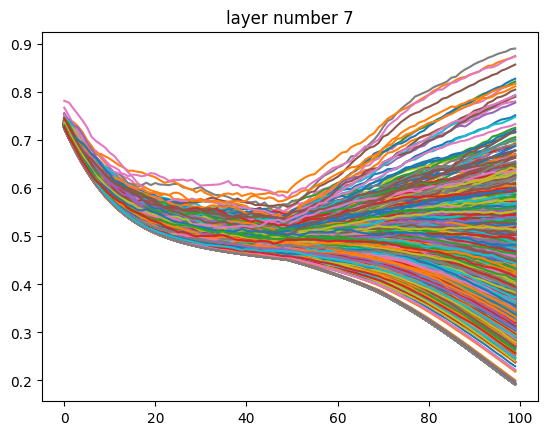

In [7]:
# Select important neurons

import math

def train_student_first_stage(student):
    device = torch.device('cuda:1')
    student.to(device)

    optimizer1 = SGD(student.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
    scheduler1 = MultiStepLR(optimizer1, milestones=[50, 70], gamma=0.1)
    optimizer2 = SGD(student.gate_parameters(), lr=0.2, momentum=0.9)
    
    history = []
    gate_values = []
    alpha = 0.01
    for _ in range(100):
        alpha += 0.01 * math.sqrt(alpha)
        student.train()
        running_training_main_loss = 0
        running_training_l0_loss = 0
        correct_answers_train = 0
        total_train = 0

        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)
            optimizer1.zero_grad()
            optimizer2.zero_grad()

            outputs = student(data)
            main_loss = F.cross_entropy(outputs, targets)
            l0_loss = student.l0_loss()
            loss = main_loss + alpha * l0_loss
            loss.backward()

            optimizer1.step()
            optimizer2.step()

            running_training_main_loss += main_loss.item()
            running_training_l0_loss += l0_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_answers_train += (predicted == targets).sum().item()
            total_train += len(targets)

        student.eval()
        running_test_loss = 0
        correct_answers_test = 0
        total_test = 0

        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            outputs = student(data)
            loss = F.cross_entropy(outputs, targets)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_answers_test += (predicted == targets).sum().item()
            total_test += len(targets)

        scheduler1.step()

        print(alpha, (running_training_main_loss / len(train_loader), running_training_l0_loss / len(train_loader),
                        running_test_loss / len(test_loader), correct_answers_train / total_train,
                        correct_answers_test / total_test))

        history.append((running_training_main_loss / len(train_loader), running_training_l0_loss / len(train_loader),
                        running_test_loss / len(test_loader), correct_answers_train / total_train,
                        correct_answers_test / total_test))
        gate_values.append(student.gate_values())

        plot_gate_values(gate_values, 2)
    return history, gate_values

train_student_first_stage(student)

In [8]:
torch.save(student.state_dict(), "students/std1.pt")

In [9]:
# Select final student

out_student = Teacher()

ln = 0
out_gate = torch.ones(3, dtype=torch.bool)
for i in range(22):
    if type(out_student.features[i]) == nn.Conv2d:
        source = student.features[i+ln]
        in_gate = out_gate
        out_gate = student.features[i+ln+2].important_indices()
        
        out_student.features[i] = l0.compress_conv2d(source, in_gate, out_gate)
        ln += 1

def compress_final_linear(layer: nn.Linear, in_important_indices) -> nn.Linear:
    compressed = nn.Linear(len(in_important_indices), layer.out_features, bias=False)
    compressed.weight.data = layer.weight.data[:, in_important_indices].detach().clone()
    return compressed


out_student.classifier = compress_final_linear(student.classifier, out_gate)

in _make_layers [Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [10]:
device = "cuda:1"
out_student.to(device)


out_student.eval()                                                                                             
running_test_loss = 0                                                                                      
correct_answers_test = 0                                                                                   
total_test = 0

for data, targets in test_loader:                                                                          
    data = data.to(device)                                                                                 
    targets = targets.to(device)                                                                           
    outputs = out_student(data)                                                                                
    loss = F.cross_entropy(outputs, targets)                                                               
    running_test_loss += loss.item()                                                                       
    _, predicted = torch.max(outputs.data, 1)                                                              
    correct_answers_test += (predicted == targets).sum().item()                                            
    total_test += len(targets) 
    
running_test_loss / len(test_loader), correct_answers_test / total_test

(1.0906119523923608, 0.7989)

In [11]:
# Finetune final student

def train_student_second_stage(student):
    device = torch.device('cuda:1')
    student.to(device)

    optimizer = SGD(student.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
    scheduler = MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

    history = []
    for epoch in range(100):
        student.train()
        running_training_loss = 0
        correct_answers_train = 0
        total_train = 0

        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = student(data)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()

            running_training_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_answers_train += (predicted == targets).sum().item()
            total_train += len(targets)

        student.eval()
        running_test_loss = 0
        correct_answers_test = 0
        total_test = 0

        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            outputs = student(data)
            loss = F.cross_entropy(outputs, targets)

            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_answers_test += (predicted == targets).sum().item()
            total_test += len(targets)

        scheduler.step()
        print(epoch, (running_training_loss / len(train_loader), running_test_loss / len(test_loader),
                        correct_answers_train / total_train,
                        correct_answers_test / total_test))

        history.append((running_training_loss / len(train_loader), running_test_loss / len(test_loader),
                        correct_answers_train / total_train,
                        correct_answers_test / total_test))
    return history

train_student_second_stage(out_student)

0 (0.6713221887950702, 0.5966990695724005, 0.7783, 0.8157)
1 (0.4998739929607762, 0.5744960851307157, 0.83266, 0.8219)
2 (0.458731358161058, 0.527990034486674, 0.84908, 0.8309)
3 (0.43229982878088646, 0.5795382019839709, 0.85588, 0.8164)
4 (0.4095996030608711, 0.5755854943130589, 0.86456, 0.8121)
5 (0.3936465144386072, 0.467469940457163, 0.86852, 0.8504)
6 (0.38757588479982313, 0.516851055471203, 0.87124, 0.8342)
7 (0.38115510112031953, 0.47163911409015896, 0.87176, 0.8481)
8 (0.381004452286169, 0.5274604502358015, 0.87274, 0.8253)
9 (0.3745752382842476, 0.47267418948909906, 0.87616, 0.8526)
10 (0.3707359637064702, 0.4546032480046719, 0.8756, 0.8535)
11 (0.36842304311902324, 0.5436161020888558, 0.87682, 0.8186)
12 (0.36129295700193975, 0.4708657690995856, 0.87878, 0.8461)
13 (0.35563781731726263, 0.46156325351588334, 0.88092, 0.8545)
14 (0.35628360776645146, 0.5262911421588704, 0.88102, 0.8308)
15 (0.3501579888793818, 0.4456289957595777, 0.88174, 0.8522)
16 (0.34994384432997544, 0.4871

[(0.6713221887950702, 0.5966990695724005, 0.7783, 0.8157),
 (0.4998739929607762, 0.5744960851307157, 0.83266, 0.8219),
 (0.458731358161058, 0.527990034486674, 0.84908, 0.8309),
 (0.43229982878088646, 0.5795382019839709, 0.85588, 0.8164),
 (0.4095996030608711, 0.5755854943130589, 0.86456, 0.8121),
 (0.3936465144386072, 0.467469940457163, 0.86852, 0.8504),
 (0.38757588479982313, 0.516851055471203, 0.87124, 0.8342),
 (0.38115510112031953, 0.47163911409015896, 0.87176, 0.8481),
 (0.381004452286169, 0.5274604502358015, 0.87274, 0.8253),
 (0.3745752382842476, 0.47267418948909906, 0.87616, 0.8526),
 (0.3707359637064702, 0.4546032480046719, 0.8756, 0.8535),
 (0.36842304311902324, 0.5436161020888558, 0.87682, 0.8186),
 (0.36129295700193975, 0.4708657690995856, 0.87878, 0.8461),
 (0.35563781731726263, 0.46156325351588334, 0.88092, 0.8545),
 (0.35628360776645146, 0.5262911421588704, 0.88102, 0.8308),
 (0.3501579888793818, 0.4456289957595777, 0.88174, 0.8522),
 (0.34994384432997544, 0.487181273630